In [1]:
from tscsRL.environments.RadiiTSCSEnv import DiscreteRadiiTSCSEnv, ContinuousRadiiTSCSEnv
from tscsRL import utils
from tscsRL.agents import ddqn, ddpg
import matplotlib.pyplot as plt
import torch
import matlab

In [2]:
## Name of the run we want to evaluate
name = 'ddpgRadii_19cyl_1500decay'

path = 'results/' + name
env_params = utils.jsonToDict(path + '/env_params.json')
agent_params = utils.jsonToDict(path + '/agent_params.json')

## Change this environment to whatever one you need
env = ContinuousRadiiTSCSEnv(
    kMax=env_params['kMax'],
    kMin=env_params['kMin'],
    nFreq=env_params['nFreq'])

## Make sure these parameters are set from the env_params
env.ep_len = env_params['ep_len']
env.grid_size = env_params['grid_size']

## Change this to the correct agent you want to evaluate
agent = ddpg.DDPGAgent(
    env.observation_space,
    env.action_space,
    agent_params,
    name)

## Set exploration rate to low amount
agent.noise_scale = 0.04

## Load weights, specify checkpoint number
agent.load_checkpoint(path + '/checkpoints/', 1350)

In [19]:
state = env.reset()
done = False

results = {
    'radii': [],
    'rms': [],
    'tscs': []}

while not done:
    results['radii'].append(env.radii)
    results['rms'].append(env.RMS)
    results['tscs'].append(env.TSCS)

    action = agent.select_action(state)
    nextState, reward, done, info = env.step(action)

    state = nextState

## Initial stuff
initialRadii = results['radii'][0]
initialRMS = results['rms'][0]
initialTSCS = results['tscs'][0]

## Optimal stuff
minIdx = results['rms'].index(min(results['rms']))
optimalRadii = results['radii'][minIdx]
optimalRMS = results['rms'][minIdx]
optimalTSCS = results['tscs'][minIdx]

print('RESULTS:')
print(f'Initial radii: {initialRadii}')
print(f'Initial RMS: {initialRMS}')
print(f'Initial TSCS: {initialTSCS}')
print()
print(f'Min radii: {optimalRadii}')
print(f'Min rms: {optimalRMS}')
print(f'Min tscs: {optimalTSCS}')

RESULTS:
Initial radii: tensor([[0.4999, 0.7806, 0.4412, 0.6120, 0.3252, 0.8184, 0.3068, 0.6144, 0.6012,
         0.9435, 0.8871, 0.5352, 0.9157, 0.5196, 0.3831, 0.6286, 0.8075, 0.4702,
         0.4634]])
Initial RMS: tensor([[2.2804]])
Initial TSCS: tensor([[2.2824, 2.3022, 2.3141, 2.3185, 2.3161, 2.3073, 2.2931, 2.2740, 2.2511,
         2.2250, 2.1969]])

Min radii: tensor([[0.3805, 0.3849, 0.2520, 0.2685, 0.5426, 0.5591, 0.2642, 0.3000, 0.5243,
         0.8717, 0.6661, 0.2862, 0.3473, 0.5173, 0.9150, 0.7972, 0.2938, 0.2874,
         0.7070]], dtype=torch.float64)
Min rms: tensor([[0.6636]])
Min tscs: tensor([[0.6832, 0.6751, 0.6670, 0.6596, 0.6536, 0.6498, 0.6488, 0.6513, 0.6577,
         0.6684, 0.6837]])


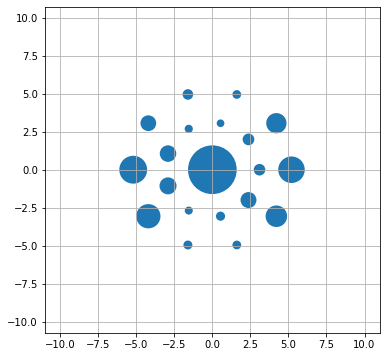

In [20]:
env.renderIMG(optimalRadii)

In [ ]:
env2 = DiscreteRadiiTSCSEnv(
    1,
    0.001,
    nFreq=100)

env.ep_len = env_params['ep_len']
env.grid_size = env_params['grid_size']

In [ ]:
env2.setMetric(initialRadii)
large_initial = env2.TSCS
env2.setMetric(optimalRadii)
large_final = env2.TSCS

In [ ]:
x = env2.eng.transpose(matlab.double(*env2.center_config.tolist()))
av = matlab.double([[1.6]])
M = matlab.double([[1]])

c_p = matlab.double([[env2.c_p]])
rho_sh = matlab.double([[env2.rho_sh]])

kMax = matlab.double([[1]])
kMin = matlab.double([[0.001]])
nFreq = matlab.double([[100]])

tscs = torch.tensor(env2.eng.getMetric_thinShells_radii_material(x, M, av, c_p, rho_sh, kMax, kMin, nFreq)).T

In [ ]:
plt.plot(large_initial[0])
plt.plot(large_final[0])
plt.plot(tscs[0])

In [18]:
state = env.reset()

In [19]:
x = env.all_config.view(1, 2 * env.nCyl)
radii = torch.cat([env.radii, env.center_radii], dim=-1)

In [101]:
x = torch.tensor([[0.0, 0.0]])
radii = torch.tensor([[1.6]])
c_pv = matlab.double(torch.tensor([[5480.0]]).tolist())
rho_shv = matlab.double(torch.tensor([[8850.0]]).tolist())

In [102]:
x = env.eng.transpose(matlab.double(*x.tolist()))
av = env.eng.transpose(matlab.double(*radii.tolist()))

# tscs = env.eng.getMetric_thinShells_radii_material(x, env.M, av, env.c_pv, env.rho_shv, env.kMax, env.kMin, env.nFreq)
tscs = env.eng.getMetric_thinShells_radii_material(x, 1, av, c_pv, rho_shv, env.kMax, env.kMin, env.nFreq)

env.TSCS = torch.tensor(tscs).T
env.RMS = env.TSCS.pow(2).mean().sqrt().view(1,1)

In [103]:
env.TSCS

tensor([[0.4629, 0.5000, 0.5385, 0.5786, 0.6201, 0.6630, 0.7073, 0.7528, 0.7996,
         0.8476, 0.8967]])

In [104]:
env.RMS

tensor([[0.6837]])

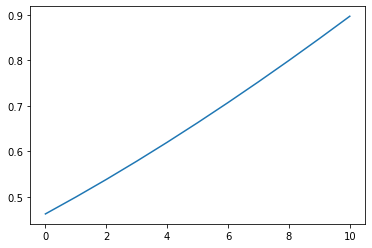

In [105]:
plt.plot(env.TSCS[0])

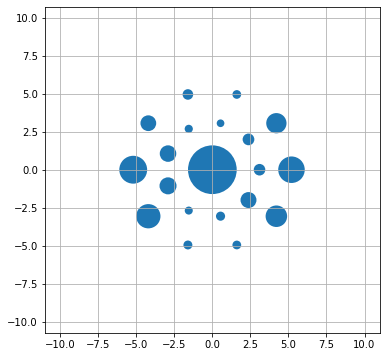

In [106]:
env.center_radii = torch.ones(1, env.center_M) * 1.6
env.radii = torch.tensor([[0.3805, 0.3849, 0.2520, 0.2685, 0.5426, 0.5591, 0.2642, 0.3000, 0.5243,
         0.8717, 0.6661, 0.2862, 0.3473, 0.5173, 0.9150, 0.7972, 0.2938, 0.2874,
         0.7070]], dtype=torch.float64)
env.renderIMG(env.radii)

In [107]:
env.setMetric(env.radii)
env.RMS

tensor([[0.6636]])